# Uncomment if using Google Colab with Google drive

In [ ]:
## Uncomment it if you are using Google Collab
import os
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/cmpt353-group-project/

# Installing and Importing packages

In [ ]:
#installations
!pip install psaw

# Yahoo Finance API
!pip install yfinance

!pip install pandas-datareader

## to run in Google collab, uncomment this 

##reference from https://newbedev.com/how-to-install-ta-lib-in-google-colab
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

!pip install transformers requests
!pip install quandl

## when running in jupyter, 
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
# import talib



In [3]:
import pandas as pd
import numpy as np
import re
import difflib
import matplotlib.pyplot as plt
import datetime as dt

from pandas_datareader import data
import datetime
from datetime import date

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

from psaw import PushshiftAPI

import yfinance as yf
yf.pdr_override()

import talib

from transformers import AutoTokenizer, AutoModelForSequenceClassification 
import requests
import torch 
import seaborn
seaborn.set()

from scipy import stats
from sklearn.metrics import classification_report



from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import quandl
import warnings
warnings.filterwarnings("ignore")




#  Importing files

In [4]:
# importing ticker symbols
tickers = pd.read_csv('./data/Processed_data/stock_ticker.csv')
df_combined_10 = pd.read_csv('./data/Processed_data/df_combined_10.csv')
df_combined = pd.read_csv('./data/Processed_data/df_combined.csv')
pred = pd.read_csv('./data/Processed_data/predictions.csv')
inflation_data = pd.read_csv('./data/Raw_data/inflation.csv')
economic_data = pd.read_csv('./data/Raw_data/EconomicData.csv')


# Finding Market Sentiment using economic data (Jyotiraditya & Ritika)

Using CSV files (Jyotiraditya & Ritika)

In [5]:
#inflation (CPI) 
inflation_data.datetime = pd.to_datetime(inflation_data['datetime'])

inflation_data.datetime = inflation_data['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y-%d-%m'))
inflation_data.datetime = pd.to_datetime(inflation_data['datetime'])

r = pd.date_range(start=inflation_data.datetime.min(), end=inflation_data.datetime.max())
inflation_data = inflation_data.set_index('datetime').reindex(r).rename_axis('datetime').reset_index()

inflation_data = inflation_data.ffill(axis=0)

inflation_data = inflation_data.set_index('datetime')
# inflation_data.to_csv('/content/drive/MyDrive/Colab_Notebooks/Features/test.csv')

#economic data
economic_data.datetime = pd.to_datetime(economic_data['datetime'])

r = pd.date_range(start=economic_data.datetime.min(), end=economic_data.datetime.max())
economic_data = economic_data.set_index('datetime').reindex(r).rename_axis('datetime').reset_index()
economic_data = economic_data.ffill(axis=0)

economic_data = economic_data.set_index('datetime')
# economic_data.to_csv('/content/drive/MyDrive/Colab_Notebooks/Features/test.csv')

# combining inflation and economic data by date
combined = inflation_data.join(economic_data,how = 'inner', lsuffix='_ticker', rsuffix='_eco')
combined = combined.ffill(axis = 0)

# extracting VIX
vix = '^VIX'
tickerdata = yf.Ticker(vix)
today = datetime.datetime.today().isoformat()
VIX_info = tickerdata.history(period = '1d', start = '1980-1-1',end = today[:10])
VIX_info['Vix_close'] = VIX_info['Close']
VIX_info = VIX_info[['Vix_close']]
# VIX_info

#combining closing price of volatility index with the data
combined = combined.join(VIX_info,how = 'inner' )

# replacing Nan values with 0
economic_data = combined.fillna(0)
economic_data


,CPI,Unemployment Rate,Real GDP (Percent Change),Effective Federal Funds Rate,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Vix_close
1990-01-02,127.400,5.4,4.5,8.23,8.25,0.00,0.00,17.240000
1990-01-03,127.400,5.4,4.5,8.23,8.25,0.00,0.00,18.190001
1990-01-04,127.400,5.4,4.5,8.23,8.25,0.00,0.00,19.219999
1990-01-05,127.400,5.4,4.5,8.23,8.25,0.00,0.00,20.110001
1990-01-08,127.400,5.4,4.5,8.23,8.25,0.00,0.00,20.260000
...,...,...,...,...,...,...,...,...
2017-03-10,243.801,4.7,1.9,0.66,1.00,0.75,0.50,11.660000
2017-03-13,243.801,4.7,1.9,0.66,1.00,0.75,0.50,11.350000
2017-03-14,243.801,4.7,1.9,0.66,1.00,0.75,0.50,12.300000
2017-03-15,243.801,4.7,1.9,0.66,1.00,0.75,0.50,11.630000


Using Quandl API (Jyotiraditya)

In [6]:

quandl.ApiConfig.api_key = "woVaCn-12gsc-zQXonLZ"


In [7]:
econ_data = quandl.get(['FRED/CPIAUCSL', 'FRED/UNRATE','FRED/GDPPOT','FRED/NGDPPOT','FRED/GDPDEF','FRED/BASE','FRED/M1','FRED/M1V','FRED/DFF','FRED/UNEMPLOY','FRED/MEHOINUSA672N','FRED/DSPIC96'], collapse = 'daily') #cpi
econ_data= econ_data.rename(columns={'FRED/CPIAUCSL - Value':'CPI', 'FRED/UNRATE - Value':'Unemployment_Rate','FRED/GDPPOT - Value':'Potential_Real_GDP','FRED/NGDPPOT - Value':'Potential_Nominal_GDP','FRED/GDPDEF - Value':'GDP_Deflator','FRED/BASE - Value':'St_Louis_Monitory_Base','FRED/M1 - Value':'M1_Money','FRED/M1V - Value':'M1_Money_Velocity','FRED/DFF - Value':'Efective_Funds_Rate','FRED/UNEMPLOY - Value':'Unemployment_Level','FRED/MEHOINUSA672N - Value':'Median_Household_Income','FRED/DSPIC96 - Value':'Disposable_personal_income'},errors="raise")

econ_data = econ_data.reset_index()
monthly_econ_data = econ_data.copy()
# r = pd.date_range(start=econ_data.Date.min(), end=econ_data.Date.max())

# econ_data = econ_data.set_index('Date').reindex(r).rename_axis('Date').reset_index()

# econ_data = econ_data.ffill(axis=0)
econ_data = econ_data.fillna(0)
econ_data = econ_data.set_index('Date')

econ_data['year_month'] = econ_data.index.to_period('M')
econ_data = econ_data.set_index('year_month')
econ_data = econ_data.groupby('year_month').mean()


# extracting VIX
vix = '^VIX'
tickerdata = yf.Ticker(vix)
today = datetime.datetime.today().isoformat()
VIX_info = tickerdata.history(period = '1d', start = '1980-1-1',end = today[:10])
VIX_info['Vix_close'] = VIX_info['Close']
VIX_info = VIX_info[['Vix_close']]
VIX_info['year_month'] = VIX_info.index.to_period('M')
VIX_info = VIX_info.groupby('year_month').mean()

econ_data = econ_data.join(VIX_info, how='inner')

#extracting S&P 500
sp500 = '^GSPC'
# sp500 = '^IXIC'
tickerdata_sp500 = yf.Ticker(sp500)
today = datetime.datetime.today().isoformat()
SP_info = tickerdata_sp500.history(start = '1920-1-1',end = today[:10], frequency = '1mo')
SP_info['SP_Close'] = SP_info['Close']
SP_info = SP_info[['SP_Close']]
SP_info['increase_percentage'] = (SP_info['SP_Close'].shift(-20))
SP_info['increase_percentage'] = ((SP_info['increase_percentage'] - SP_info['SP_Close']) / SP_info['SP_Close']) * 100
# SP_info['Year'] = SP_info.index.year
SP_info['year_month'] = SP_info.index.to_period('M')
# SP_info = SP_info.reset_index()
SP_info = SP_info.groupby('year_month').mean()
SP_info ['sentiment'] = np.where(SP_info['increase_percentage'] >= 1, 1 , 0)
SP_info = SP_info[['sentiment']]

econ_data = econ_data.join(SP_info, how='inner')


In [8]:
X=econ_data
y=X['sentiment']
# y=y.to_numpy()
X=X.drop(['sentiment'],axis=1)

# X=X.to_numpy()
X_train = X[:'2021-01']
y_train = y.loc[:'2021-01']

model = RandomForestClassifier()

model.fit(X_train, y_train);
# print('Training Score When trained on Stable stock ({}): ' + str(model.score(X_train, y_train)))

In [9]:
# predicting 
X= econ_data
y = X['sentiment']
# y = y.to_numpy()
X = X.drop(['sentiment'],axis=1)

X = X['2021-01':].values
y = y.loc['2021-01':].values

# X = X.to_numpy()
y = y.reshape(-1,1)


prediction = model.predict(X)
# prediction = prediction.reshape(-1,1)
sentiment = np.where((prediction).mean() > 0.5,'Bullish','Bearish')
print('Accumulative Stock Market Sentiment for current year : {}\n'.format(sentiment))
print('Classification Report:')
print(classification_report(y, prediction))

Accumulative Stock Market Sentiment for current year : Bullish

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.71      1.00      0.83         5

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8



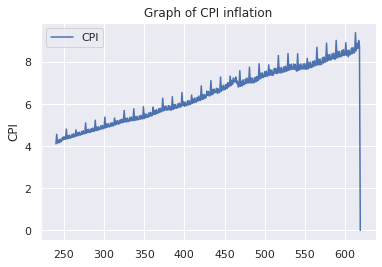

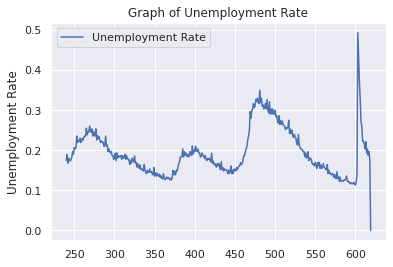

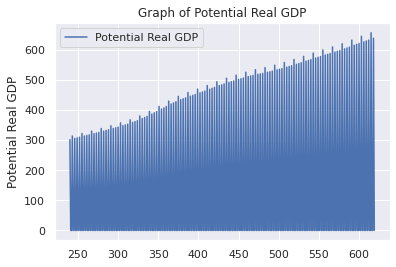

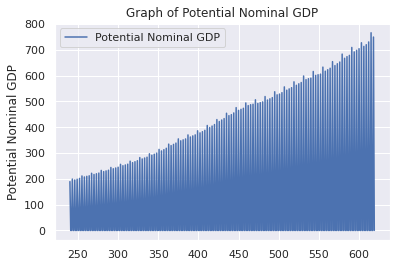

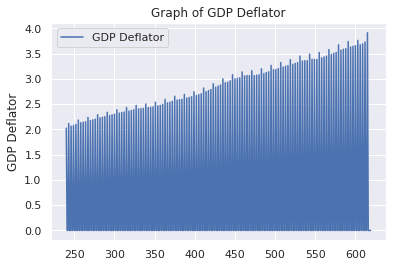

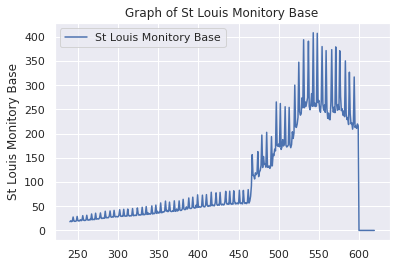

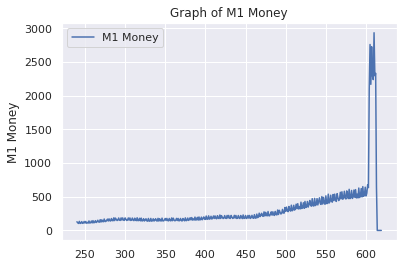

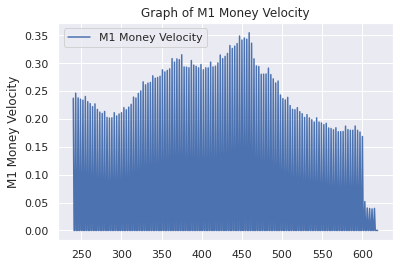

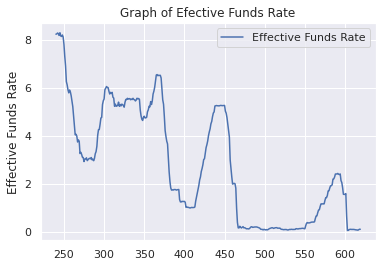

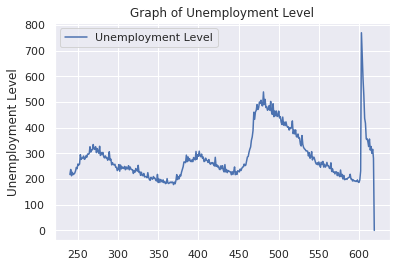

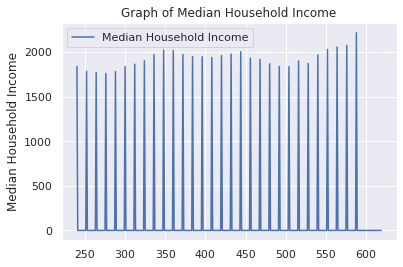

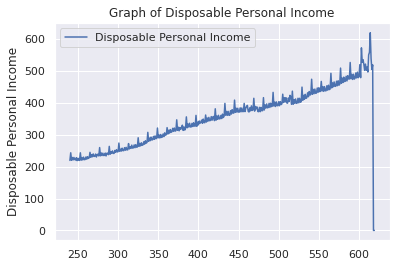

In [10]:
plt.plot(econ_data.index,econ_data.CPI, label = 'CPI')
plt.ylabel('CPI')
plt.legend()
plt.title('Graph of CPI inflation')
plt.savefig('./data/Plots/CPI.png')
plt.show()


plt.plot(econ_data.index,econ_data.Unemployment_Rate, label = 'Unemployment Rate')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.title('Graph of Unemployment Rate')
plt.savefig('./data/Plots/Unemployment_rate.png')
plt.show()


plt.plot(econ_data.index,econ_data.Potential_Real_GDP, label = 'Potential Real GDP')
plt.ylabel('Potential Real GDP')
plt.legend()
plt.title('Graph of Potential Real GDP')
plt.savefig('./data/Plots/Potnetial_real_GDP.png')
plt.show()

plt.plot(econ_data.index,econ_data.Potential_Nominal_GDP, label = 'Potential Nominal GDP')
plt.ylabel('Potential Nominal GDP')
plt.legend()
plt.title('Graph of Potential Nominal GDP')
plt.savefig('./data/Plots/Potential_Nominal_GDP.png')
plt.show()

plt.plot(econ_data.index,econ_data.GDP_Deflator, label = 'GDP Deflator')
plt.ylabel('GDP Deflator')
plt.legend()
plt.title('Graph of GDP Deflator')
plt.savefig('./data/Plots/GDP_Deflator.png')
plt.show()

plt.plot(econ_data.index,econ_data.St_Louis_Monitory_Base, label = 'St Louis Monitory Base')
plt.ylabel('St Louis Monitory Base')
plt.legend()
plt.title('Graph of St Louis Monitory Base')
plt.savefig('./data/Plots/St_Louis_Monitory_Base.png')
plt.show()

plt.plot(econ_data.index,econ_data.M1_Money, label = 'M1 Money')
plt.ylabel('M1 Money')
plt.legend()
plt.title('Graph of M1 Money')
plt.savefig('./data/Plots/M1_Money.png')
plt.show()

plt.plot(econ_data.index,econ_data.M1_Money_Velocity, label = 'M1 Money Velocity')
plt.ylabel('M1 Money Velocity')
plt.legend()
plt.title('Graph of M1 Money Velocity')
plt.savefig('./data/Plots/M1_Money_Velocity.png')
plt.show()

plt.plot(econ_data.index,econ_data.Efective_Funds_Rate, label = 'Effective Funds Rate')
plt.ylabel('Effective Funds Rate')
plt.legend()
plt.title('Graph of Efective Funds Rate')
plt.savefig('./data/Plots/Effective_Funds_Rate.png')
plt.show()

plt.plot(econ_data.index,econ_data.Unemployment_Level, label = 'Unemployment Level')
plt.ylabel('Unemployment Level')
plt.legend()
plt.title('Graph of Unemployment Level')
plt.savefig('./data/Plots/Unemployment_Level.png')
plt.show()

plt.plot(econ_data.index,econ_data.Median_Household_Income, label = 'Median Household Income')
plt.ylabel('Median Household Income')
plt.legend()
plt.title('Graph of Median Household Income')
plt.savefig('./data/Plots/Median_Household_Income.png')
plt.show()

plt.plot(econ_data.index,econ_data.Disposable_personal_income, label = 'Disposable Personal Income')
plt.ylabel('Disposable Personal Income')
plt.legend()
plt.title('Graph of Disposable Personal Income')
plt.savefig('./data/Plots/Disposable_Personal_Income.png')
plt.show()


# Extracting Historical Data from Yahoo Finance API (Ritika)

In [11]:
# extracting historical data of most talked about stock
tickerSymbol = df_combined_10['Ticker'][0]

tickerdata = yf.Ticker(tickerSymbol)

today = datetime.datetime.today().isoformat()
tickerDF = tickerdata.history(period = '1d', start = '1980-1-1',end = today[:10]) # dates will go here
print("Historical Data of {} :".format(tickerSymbol))
tickerDF

Historical Data of AMC :


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-12-18,13.794792,14.233521,13.593408,13.593408,5457200,0.0,0
2013-12-19,13.593411,14.017756,13.528680,14.017756,1605400,0.0,0
2013-12-20,14.132830,14.219138,13.953023,14.154408,737100,0.0,0
2013-12-23,14.233526,14.377371,14.024950,14.197564,698100,0.0,0
2013-12-24,14.197562,14.255100,14.024948,14.046525,213700,0.0,0
...,...,...,...,...,...,...,...
2021-08-09,32.680000,35.380001,32.349998,33.799999,81054600,0.0,0
2021-08-10,36.900002,37.160000,31.440001,31.750000,115907000,0.0,0
2021-08-11,31.580000,31.910000,29.400000,31.549999,69242900,0.0,0


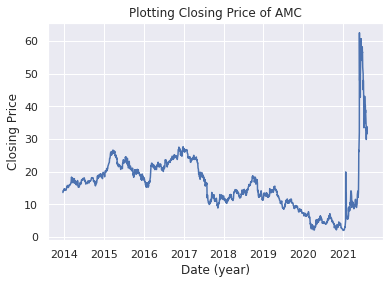

In [12]:
tickerDf = tickerDF.reset_index()
plt.plot(tickerDf.Date,tickerDf.Close)
plt.title('Plotting Closing Price of {}'.format(tickerSymbol))
plt.xlabel('Date (year)')
plt.ylabel('Closing Price')
plt.savefig('./data/Plots/Plotting_Closing_Price_of_{}.png'.format(tickerSymbol))
plt.show()

# Statistical Testing, Applying Linear Regression to train data models(Dhairya)


    count Ticker
0      54    AMC
1      20    AMD
2      15    GME
3      15   HOOD
4      13     RH
..    ...    ...
95      2     CB
96      2    FAM
97      2   ADXS
98      2   ADMP
99      2   PENN

[100 rows x 2 columns]


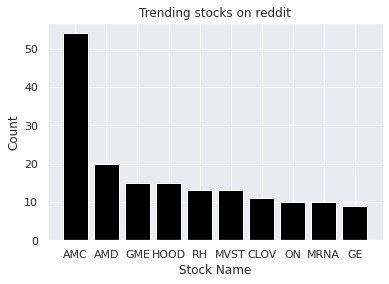


p value of normality test on count : 5.6081711223323415e-36
p value of normality test on increase percent : 1.890481498942785e-18
p value of equal variance on count and increse percent : 8.007706510335593e-11
p vaue of t-test on count and increase percent : 1.4354312688920346e-05


In [13]:

stock_info=pd.DataFrame(columns=['ticker','initial price','final price','increase percent','volume'])
df_combined=df_combined.head(100)
df_combined=df_combined.drop(['Unnamed: 0'],axis=1)
#df_combined=df_combined[df_combined['count']>=15]
print(df_combined)

#Bar Plot representing current trending stocks on social media and their count.
plt.bar(df_combined['Ticker'].head(10),df_combined['count'].head(10),color='black')
plt.xlabel('Stock Name')
plt.ylabel('Count')
plt.title('Trending stocks on reddit')
plt.savefig('./data/Plots/Trending_stocks_on_reddit.png')

plt.show()

#Extracting Relevant data for the stocks.
for i in df_combined['Ticker']:
  tick = i
  tickerdata = yf.Ticker(tick)
  today = datetime.datetime.today().isoformat()
  tickerDF = tickerdata.history(period = '1d', start = '2020-08-1',end = '2021-09-1') # dates will go here

  start = tickerDF['Close'].iloc[0]
  end = tickerDF['Close'].iloc[-1]
  if(len(tickerDF['Close'])>1):
    increased_percentage = (tickerDF['Close'].iloc[-2] - start)/start
  else:
    continue
  increased_percentage = increased_percentage *100 
  vol=tickerDF['Volume'].iloc[-2]
  stock_info= stock_info.append({'ticker': i,'initial price':start,'final price':end,'increase percent': increased_percentage,'volume':vol}, ignore_index=True)

stock_info = pd.concat([stock_info, df_combined], axis=1, join="inner") 
stock_info=stock_info.drop(['Ticker'],axis=1)
stock_info=stock_info.sort_values(by='count',ascending=False)
stock_info=stock_info.reset_index(drop=True)
stock_info=stock_info.dropna()

#Removing outliers from the data to prevent false predictions.
# stock_info=stock_info[stock_info['count']>2]
stock_info=stock_info[stock_info['increase percent']<1000]
print()
#Applying Central Limit Theoram since the data is more than 30.
print('p value of normality test on count : ' + str(stats.normaltest(stock_info['count']).pvalue))
print('p value of normality test on increase percent : ' +str(stats.normaltest(stock_info['increase percent']).pvalue))
print('p value of equal variance on count and increse percent : ' +str(stats.levene(stock_info['count'],stock_info['increase percent']).pvalue))
print('p vaue of t-test on count and increase percent : ' + str(stats.ttest_ind(stock_info['count'], stock_info['increase percent']).pvalue))

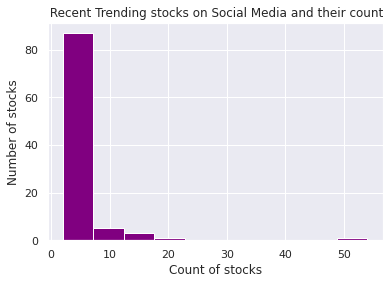

In [14]:
#Plotting Histograms for count and increase percent
plt.hist(stock_info['count'],color='purple')
plt.ylabel('Number of stocks')
plt.xlabel('Count of stocks')
plt.title(' Recent Trending stocks on Social Media and their count')
plt.savefig('./data/Plots/Recent_Trending_stocks_on_Social_Media_and_their_count.png')

plt.show()

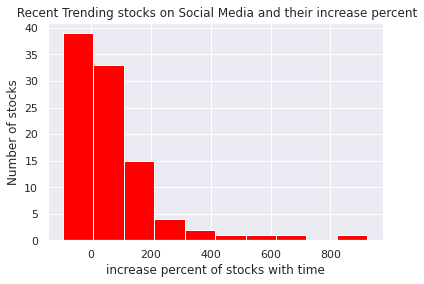

In [15]:
#Plotting Histograms for count and increase percent
plt.hist(stock_info['increase percent'],color='red')
plt.ylabel('Number of stocks')
plt.xlabel('increase percent of stocks with time')
plt.title(' Recent Trending stocks on Social Media and their increase percent')
plt.savefig('./data/Plots/Recent_Trending_stocks_on_Social_Media_and_their_increase_percent.png')
plt.show()

In [16]:
#Since the data is Right Skewed applying data transformation of Root
inc=pd.DataFrame()
count=pd.DataFrame()
inc['right']=stock_info['increase percent'].apply(np.sqrt)
count['right']=stock_info['count'].apply(np.sqrt)

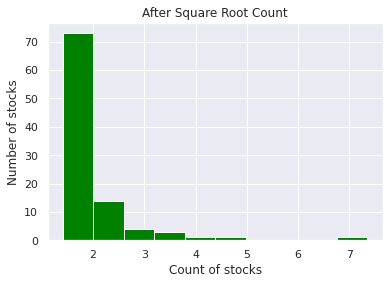

In [17]:
#Plotting count after root transformation
plt.hist(count['right'],color='green')
plt.ylabel('Number of stocks')
plt.xlabel('Count of stocks')
plt.title('After Square Root Count')

plt.savefig('./data/Plots/After_Square_Root_Count.png')

plt.show()

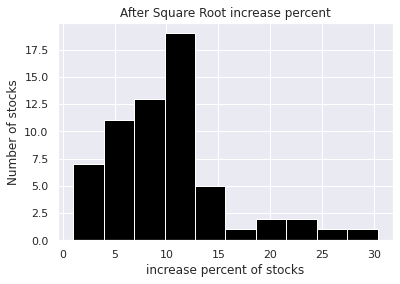

In [18]:
#Plotting increase percent after root transformation
plt.hist(inc['right'],color='black')
plt.ylabel('Number of stocks')
plt.xlabel('increase percent of stocks')
plt.title('After Square Root increase percent')
plt.savefig('./data/Plots/After_Square_Root_increase_percent.png')
plt.show()

In [19]:
#Since the data is Right Skewed applying data transformation of log
inc['left']=stock_info['increase percent'].apply(np.log)
count['left']=stock_info['count'].apply(np.log)

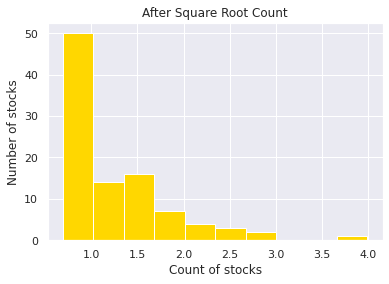

In [20]:
#Plotting count after root transformation
plt.hist(count['left'],color='gold')
plt.ylabel('Number of stocks')
plt.xlabel('Count of stocks')
plt.title('After Square Root Count')
plt.savefig('./data/Plots/After_Square_Root_Count.png')
plt.show()

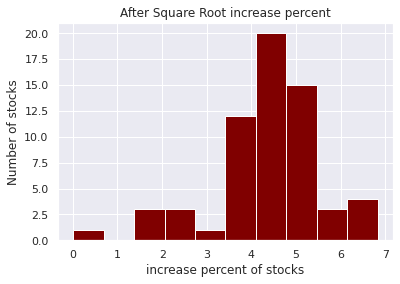

In [21]:
#Plotting increase percent after root transformation
plt.hist(inc['left'],color='maroon')
plt.ylabel('Number of stocks')
plt.xlabel('increase percent of stocks')
plt.title('After Square Root increase percent')
plt.savefig('./data/Plots/After_Square_Root_increase_percent.png')
plt.show()

In [22]:
#Using transformed to conduct test again. (Extra test because central limit applied)
count=count.dropna()
inc=inc.dropna()
print('p value of normality test for count[left] : ' + str(stats.normaltest(count['left']).pvalue))
print('p value of normality test for inc[left] : ' + str(stats.normaltest(inc['left']).pvalue))
print( 'p value of equal variance test on count[left] and inc[left] : '+ str(stats.levene(count['left'],inc['left']).pvalue))
print( 'p value of ttest on count[left] and inc[left]'+ str(stats.ttest_ind(count['left'], inc['left']).pvalue))


p value of normality test for count[left] : 8.544565875235801e-10
p value of normality test for inc[left] : 0.0014349074067649009
p value of equal variance test on count[left] and inc[left] : 0.0008684677811011709
p value of ttest on count[left] and inc[left]1.2612713251030843e-48


In [23]:
#Applying MannWhitneyU on this test to check for separate means. ( Also for information purposes)
print('p value of mann whitney yu for inc[left] and count[left] : ' + str(stats.mannwhitneyu(inc['left'],count['left']).pvalue))

p value of mann whitney yu for inc[left] and count[left] : 1.1968964869050573e-24


In [24]:
#stock_info=stock_info.head(10)
stock_info

,ticker,initial price,final price,increase percent,volume,count
0,AMC,4.110000,33.470001,704.622837,71204100,54
1,AMD,77.669998,110.550003,37.118582,60625700,20
3,HOOD,34.820000,50.630001,38.138997,13426200,15
4,RH,293.890015,722.940002,151.291294,324200,13
5,MVST,10.150000,11.480000,9.753702,4868800,13
...,...,...,...,...,...,...
95,KPLT,10.175000,3.350000,-63.243244,5455900,2
96,NAT,4.172000,2.230000,-45.829344,2023300,2
97,QS,9.900000,21.740000,127.474761,4011400,2
98,ACI,14.496679,29.850000,104.322660,1937500,2


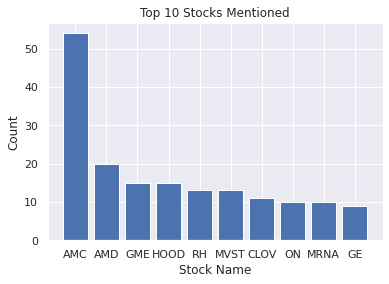

In [25]:
#Bar chart of stock count
plt.bar(df_combined['Ticker'].head(10),df_combined['count'].head(10))
plt.xlabel('Stock Name')
plt.ylabel('Count')
plt.title('Top 10 Stocks Mentioned')
plt.savefig('./data/Plots/Top_10_Stocks_Mentioned.png')

plt.show()


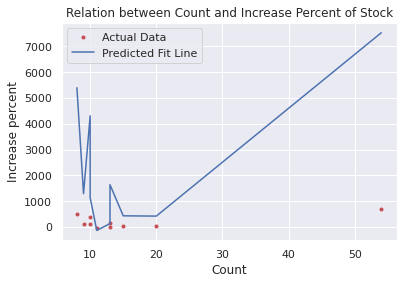

In [26]:

#Plotting the count vs increse percent graph
fit = stats.linregress(stock_info['count'].head(10), stock_info['increase percent'].head(10))
# print(stock_info['increase percent'].head(10))

plt.plot(stock_info['count'].head(10),stock_info['increase percent'].head(10),'r.', label = 'Actual Data')
plt.plot(stock_info['count'].head(10),stock_info['increase percent'].head(10)*fit.slope + fit.intercept,'b-', label = 'Predicted Fit Line')
plt.xlabel('Count')
plt.ylabel('Increase percent')
plt.title('Relation between Count and Increase Percent of Stock')
plt.legend()
plt.savefig('./data/Plots/Relation_between_Count_and_Increase_Percent_of_Stock.png')

plt.show() 


In [27]:
# Fitting the data into a machine learning model
stock_info['days']=stock_info['initial price']/stock_info['initial price']*365
stock_info=stock_info[stock_info['days'].notnull()]
stock_info['days']=stock_info['days'].astype(int)


y = []
X= []
y = stock_info['final price']
y = y.to_numpy()
X = stock_info
# print(X_train)
X = X.drop(['ticker','final price'], axis = 1)
# print(X_train)
X = X.to_numpy()
X_train,X_valid,y_train,y_valid=train_test_split(X,y)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y)
model = make_pipeline(
    #PolynomialFeatures(degree=8, include_bias=True),
    LinearRegression(fit_intercept=True)
)

model.fit(X_train,y_train);
# print()
print( 'Validation score : ' + str(model.score(X_valid, y_valid)))



Validation score : 0.846418522020082


#Prediction of stocks using Linear Regression model based on statistical analysis (Dhairya)


In [28]:
# #Predicting final price of Stocks
df_combined_RE = df_combined
df_combined_RE['count'] = 1
df_combined_RE['Ticker'] = df_combined_RE['Ticker'].str.upper()
df_combined_RE['contains'] = df_combined_RE['Ticker'].isin(pred['ticker'])
df_combined_RE= df_combined_RE[df_combined_RE['contains'] != False]

stock_info_RE=pd.DataFrame(columns=['ticker','initial price','increase','volume'])

# #reference from https://datascienceparichay.com/article/pandas-groupby-count-of-rows-in-each-group/
df_combined_RE= df_combined_RE.groupby('Ticker').count()
df_combined_RE= df_combined_RE.drop(['contains'], axis = 1)
df_combined_RE= df_combined_RE.reset_index(drop=False)
df_combined_RE=df_combined_RE.sort_values('count', ascending = False)
df_combined_RE=df_combined_RE.reset_index(drop=True)
# print(df_combined_RE)

for i in df_combined_RE['Ticker']:
  tickerSymbol = i
  tickerdata = yf.Ticker(tickerSymbol)
  today = datetime.datetime.today().isoformat()
  tickerDF = tickerdata.history(period = '1d', start = '2021-08-1',end = '2021-08-7') # dates will go here
  start = tickerDF['Close'].iloc[0]
  end = tickerDF['Close'].iloc[-1]
  increased_percentage = (end-start)/start
  increased_percentage = increased_percentage *100 
  stock_info_RE= stock_info_RE.append({'ticker': i,'initial price':start,'increase':increased_percentage,'volume':tickerDF['Volume'].iloc[-1]}, ignore_index=True)


stock_info_RE = pd.concat([stock_info_RE, df_combined_RE], axis=1, join="inner") 
stock_info_RE=stock_info_RE.drop(['Ticker'],axis=1)
stock_info_RE=stock_info_RE.sort_values(by='count',ascending=False)
stock_info_RE=stock_info_RE.reset_index(drop=True)
stock_info_RE['days']=stock_info_RE['initial price']/stock_info_RE['initial price']*7
stock_info_RE[stock_info_RE['days'].notnull()]
stock_info_RE['days']=stock_info_RE['days'].astype(int)
stock_info_RE=stock_info_RE.dropna()

result=stock_info_RE

#result=result[result['increase']>0]
result=result.drop(['ticker'],axis=1)
X_pred=[]
X_pred=result.to_numpy()
# print(stock_info_RE)
# stock_info_RE['prediction']
# print(X_pred)

temp = model.predict(X_pred)
y_pred=model.predict(X_pred)
stock_info_RE['prediction']=y_pred

# print(stock_info_RE)

#Predicting model score
# print(model.score(X,y))
print('Prediction score on data : ' + str(model.score(X_pred,stock_info_RE['prediction'])))

print()
print(stock_info_RE)

#Splitting the Data to perform testing





Prediction score on data : 1.0

  ticker  initial price  increase    volume  count  days   prediction
0    AMC      35.200001 -7.102273  52649800      1     7    42.543596
1    GME     157.649994 -3.729775   1348100      1     7   280.370219
2   TSLA     709.669983 -1.489426  15576200      1     7  1342.709683


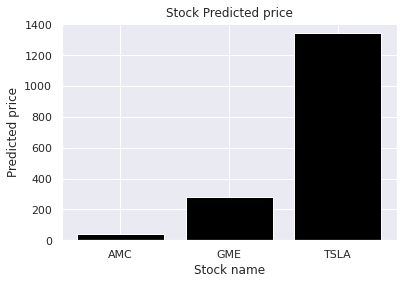

In [29]:
#Plotting Increase vs count plot
plt.bar(stock_info_RE['ticker'],stock_info_RE['prediction'],color='black')
plt.xlabel('Stock name')
plt.ylabel('Predicted price')
plt.title('Stock Predicted price')

plt.savefig('./data/Plots/Stock_Predicted_price.png')
plt.show()


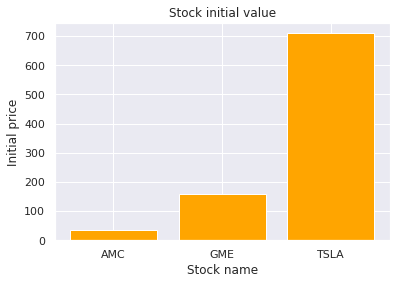

In [30]:
plt.bar(stock_info_RE['ticker'],stock_info_RE['initial price'],color='orange')
plt.xlabel('Stock name')
plt.ylabel('Initial price')
plt.title('Stock initial value')
plt.savefig('./data/Plots/Stock_initial_value.png')
plt.show()

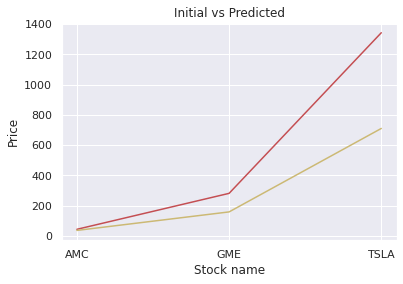

In [31]:
plt.plot(stock_info_RE['ticker'],stock_info_RE['prediction'],'r-')
plt.plot(stock_info_RE['ticker'],stock_info_RE['initial price'],'y-')
plt.xlabel('Stock name')
plt.ylabel('Price')
plt.title('Initial vs Predicted')
plt.savefig('./data/Plots/Initial_vs_Predicted.png')

plt.show()

# Random Forest Classifier to predict stock prices using technical analysis 
(Jyotiraditya, Ritika, Navjot)

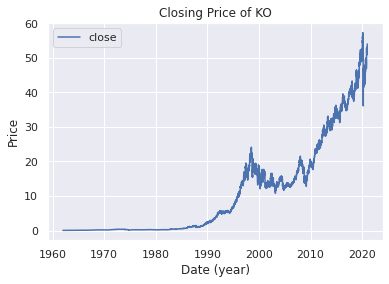

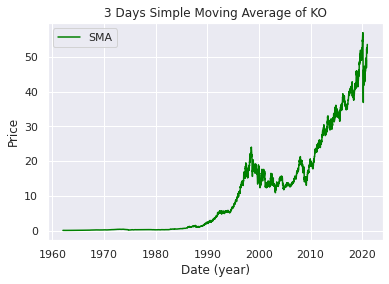

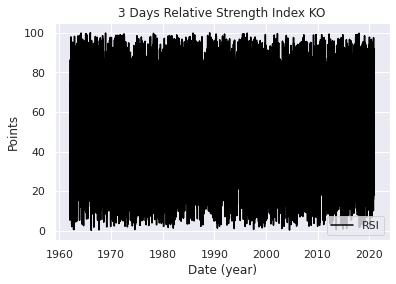

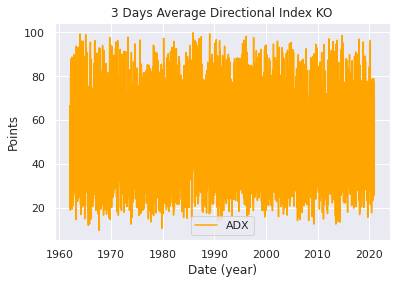

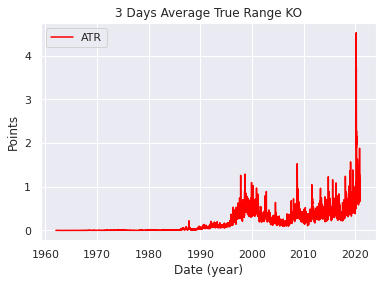

Training Score: 0.9999913793530582
Validation Score: 0.9801340825444089


In [32]:
tickersymbol='KO'
tickerdata = yf.Ticker(tickersymbol)
tickerDF = tickerdata.history(period = '1d', start = '1920-01-01',end = '2021-01-01')
closing = tickerDF['Close']
tickerDF['SMA'] = talib.SMA(closing, timeperiod=3)
tickerDF['EMA'] = talib.EMA(closing, timeperiod=3)
tickerDF['RSI'] = talib.RSI(closing, timeperiod=3)
tickerDF['ADX'] = talib.ADX(tickerDF['High'], tickerDF['Low'], closing, timeperiod=3)
tickerDF['ATR'] = talib.ATR(tickerDF['High'], tickerDF['Low'], closing, timeperiod=3)
ticker_df = tickerDF.drop(['Dividends', 'Stock Splits'], axis=1).dropna()

# ticker_df = ticker_df[['Close', 'Volume', 'SMA', 'EMA', 'RSI', 'ADX', 'ATR']]

plot = plt.plot(tickerDF['Close'], label='close')
plt.title('Closing Price of {}'.format(tickersymbol))
plt.xlabel('Date (year)')
plt.ylabel('Price')
plt.legend()
plt.savefig('./data/Plots/Closing_Price_of{}.png'.format(tickersymbol))
plt.show()

plot = plt.plot(ticker_df['SMA'], color='Green', label='SMA')
plt.title('3 Days Simple Moving Average of {}'.format(tickersymbol))
plt.xlabel('Date (year)')
plt.ylabel('Price')
plt.legend()
plt.savefig('./data/Plots/3_days_simple_moving_average_of_{}.png'.format(tickersymbol))
plt.show()

plot = plt.plot(ticker_df['RSI'], color='black', label='RSI')
plt.title('3 Days Relative Strength Index {}'.format(tickersymbol))
plt.xlabel('Date (year)')
plt.ylabel('Points')
plt.legend()
plt.savefig('./data/Plots/3_days_relative_strength_Index{}.png'.format(tickersymbol))
plt.show()

plot = plt.plot(ticker_df['ADX'], color='orange', label='ADX')
plt.title('3 Days Average Directional Index {}'.format(tickersymbol))
plt.xlabel('Date (year)')
plt.ylabel('Points')
plt.legend()
plt.savefig('./data/Plots/3_days_average_Directional_index{}.png'.format(tickersymbol))
plt.show()

plot = plt.plot(ticker_df['ATR'], color='red', label='ATR')
plt.title('3 Days Average True Range {}'.format(tickersymbol))
plt.xlabel('Date (year)')
plt.ylabel('Points')
plt.legend()
plt.savefig('./data/Plots/3_days_average_true_range{}.png'.format(tickersymbol))
plt.show()

X = ticker_df
y = X['Close']
# y=y.to_numpy()
X = X.drop(['Close'],axis=1)
# X=X.to_numpy()
# X_train, X_valid, y_train, y_valid = train_test_split(X, y)
X_train = X[:'2020-06-01'].to_numpy()
y_train = y.loc[:'2020-06-01'].to_numpy()
X_valid = X['2020-06-01':].to_numpy()
y_valid = y['2020-06-01':].to_numpy()
y_valid = y_valid.reshape(-1,1)
y_train = y_train.reshape(-1,1)


scaler =  MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)


scaler_predict = MinMaxScaler(feature_range=(0,1))
y_valid = scaler_predict.fit_transform(y_valid)
y_train = scaler_predict.fit_transform(y_train)


model = RandomForestRegressor(9, max_depth=20)
model.fit(X_train, y_train)
prediction = model.predict(X_valid)
prediction = prediction.reshape(-1,1)
prediction = scaler_predict.inverse_transform(prediction)
print('Training Score: ' + str(model.score(X_train, y_train)))
print('Validation Score: ' + str(model.score(X_valid, y_valid)))



In [33]:
# predicting on the most hyped Stock Close Price
tickersymbol= df_combined_10['Ticker'][0]
tickerdata = yf.Ticker(tickersymbol)
tickerDF = tickerdata.history(period = '1d', start = '2021-01-01',end = '2021-08-08')
closing = tickerDF['Close']
tickerDF['SMA'] = talib.SMA(closing, timeperiod=3)
tickerDF['EMA'] = talib.EMA(closing, timeperiod=3)
tickerDF['RSI'] = talib.RSI(closing, timeperiod=3)
tickerDF['ADX'] = talib.ADX(tickerDF['High'], tickerDF['Low'], closing, timeperiod=3)
tickerDF['ATR'] = talib.ATR(tickerDF['High'], tickerDF['Low'], closing, timeperiod=3)
ticker_df = tickerDF.drop(['Dividends', 'Stock Splits'], axis=1).dropna()


X = ticker_df
ticker_df = ticker_df.reset_index()
y = X['Close']
y = y.to_numpy()
X = X.drop(['Close'],axis=1)

X = X.to_numpy()
y = y.reshape(-1,1)
y = scaler_predict.fit_transform(y)
X = scaler.fit_transform(X)

prediction = model.predict(X)
prediction = prediction.reshape(-1,1)
prediction = scaler_predict.inverse_transform(prediction)
print('Score after predicting the Close Price for {} using Technical Analysis : '.format(tickersymbol) + str(model.score(X, y)))
# print(ticker_df['Close'])
# prediction


Score after predicting the Close Price for AMC using Technical Analysis : 0.9909056026838877


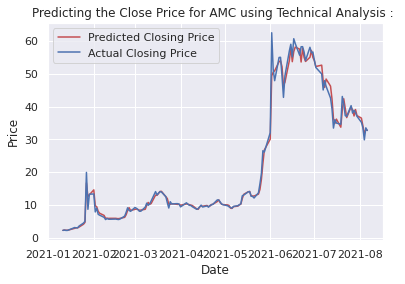

In [34]:
plt.plot(ticker_df.Date, prediction, 'r-', label = 'Predicted Closing Price')
plt.plot(ticker_df.Date, ticker_df['Close'], 'b-', label = 'Actual Closing Price')
plt.title('Predicting the Close Price for {} using Technical Analysis : '.format(tickersymbol))
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('./data/Plots/Predicting_the_Close_Price_using_Technical_Analysis_of_{}.png'.format(tickersymbol))
plt.show()

# Buy Sell Recomendations using Technical Analysis (Jyotiraditya & Ritika)

In [35]:
# Training on a stable stock
tickersymbol='KO'
tickerdata = yf.Ticker(tickersymbol)
tickerDF = tickerdata.history(period = '1d', start = '1920-01-01',end = '2020-02-01')
closing = tickerDF['Close']

# Making Technical indcators as a feature to train
tickerDF['SMA_5'] = talib.SMA(closing, timeperiod=5)
tickerDF['SMA_15'] = talib.SMA(closing, timeperiod=15)
tickerDF['EMA_5'] = talib.EMA(closing, timeperiod=5)
tickerDF['EMA_15'] = talib.EMA(closing, timeperiod=15)
tickerDF['RSI_5'] = talib.RSI(closing, timeperiod=5)
tickerDF['RSI_15'] = talib.RSI(closing, timeperiod=15)
tickerDF['ADX_5'] = talib.ADX(tickerDF['High'], tickerDF['Low'], closing, timeperiod=5)
tickerDF['ADX_15'] = talib.ADX(tickerDF['High'], tickerDF['Low'], closing, timeperiod=15)
tickerDF['ATR_5'] = talib.ATR(tickerDF['High'], tickerDF['Low'], closing, timeperiod=5)
tickerDF['ATR_15'] = talib.ATR(tickerDF['High'], tickerDF['Low'], closing, timeperiod=15)

macd , macdsignal, macdhist= talib.MACD(closing, fastperiod=12, slowperiod=26, signalperiod=9)

macd_data = pd.DataFrame(macd,columns = ['MACD'])

tickerDF = tickerDF.join(macd_data, how ="inner")

ticker_df = tickerDF
ticker_df['weekly_close'] = ticker_df['Close'].shift(-6)
ticker_df['Percent_change'] = ((ticker_df['weekly_close'] - ticker_df['Open'])/(ticker_df['Open']) * 100).shift(-1)
ticker_df['buy/sell'] = np.where(ticker_df['Percent_change']>0,1,0)
ticker_df = ticker_df.dropna().copy()
ticker_df = ticker_df.drop(['Dividends', 'Stock Splits','Open','Low','High','Volume','Close','Percent_change','weekly_close'], axis=1).dropna()


X=ticker_df
y=X['buy/sell']
# y=y.to_numpy()
X=X.drop(['buy/sell'],axis=1)

# X=X.to_numpy()
X_train = X[:'2020-02-01']
y_train = y.loc[:'2020-02-01']

model = RandomForestClassifier()


model.fit(X_train, y_train)
print('Training Score When trained on Stable stock ({}): '.format(tickersymbol) + str(model.score(X_train, y_train)))

Training Score When trained on Stable stock (KO): 1.0


In [36]:
#Prediting Hyped Stock

tickersymbol= df_combined_10['Ticker'][0]
tickerdata = yf.Ticker(tickersymbol)
tickerDF = tickerdata.history(period = '1d', start = '2020-02-01',end = '2021-08-10')
closing = tickerDF['Close']

tickerDF['SMA_5'] = talib.SMA(closing, timeperiod=5)
tickerDF['SMA_15'] = talib.SMA(closing, timeperiod=15)
tickerDF['EMA_5'] = talib.EMA(closing, timeperiod=5)
tickerDF['EMA_15'] = talib.EMA(closing, timeperiod=15)
tickerDF['RSI_5'] = talib.RSI(closing, timeperiod=5)
tickerDF['RSI_15'] = talib.RSI(closing, timeperiod=15)
tickerDF['ADX_5'] = talib.ADX(tickerDF['High'], tickerDF['Low'], closing, timeperiod=5)
tickerDF['ADX_15'] = talib.ADX(tickerDF['High'], tickerDF['Low'], closing, timeperiod=15)
tickerDF['ATR_5'] = talib.ATR(tickerDF['High'], tickerDF['Low'], closing, timeperiod=5)
tickerDF['ATR_15'] = talib.ATR(tickerDF['High'], tickerDF['Low'], closing, timeperiod=15)

macd , macdsignal, macdhist= talib.MACD(closing, fastperiod=12, slowperiod=26, signalperiod=9)

macd_data = pd.DataFrame(macd,columns = ['MACD'])

tickerDF = tickerDF.join(macd_data, how ="inner")

ticker_df = tickerDF
ticker_df['weekly_close'] = ticker_df['Close'].shift(-6)
ticker_df['Percent_change'] = ((ticker_df['weekly_close'] - ticker_df['Open'])/(ticker_df['Open']) * 100).shift(-1)
ticker_df['buy/sell'] = np.where(ticker_df['Percent_change']>0,1,0)
ticker_df = ticker_df.dropna().copy()
buy_sell_df = ticker_df.copy()
ticker_df = ticker_df.drop(['Dividends', 'Stock Splits','Open','Low','High','Volume','Close','Percent_change','weekly_close'], axis=1).dropna()

X= ticker_df
y = X['buy/sell']
y = y.to_numpy()
X = X.drop(['buy/sell'],axis=1)
X = X.to_numpy()
y = y.reshape(-1,1)


prediction = model.predict(X)
prediction = prediction.reshape(-1,1)

print('Prediction Score with hyped Stock ({}) : '.format(tickersymbol) + str(model.score(X, y)))

Prediction Score with hyped Stock (AMC) : 0.4956268221574344


In [37]:
buy_sell_df
buy_sell_df = buy_sell_df[['Close']]
buy_sell_df['buy/sell'] = prediction
buy_sell_df
buy_df = buy_sell_df.drop(buy_sell_df[buy_sell_df['buy/sell'] == 0].index)
sell_df = buy_sell_df.drop(buy_sell_df[buy_sell_df['buy/sell'] == 1].index)

buy_sell_df = buy_sell_df.reset_index()

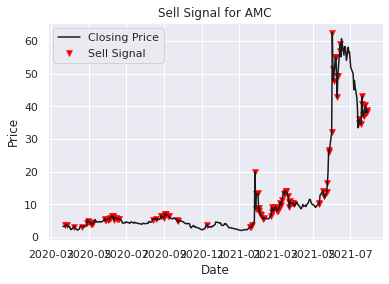

In [38]:
sell_df = sell_df.reset_index()
plt.plot(buy_sell_df.Date,buy_sell_df.Close,'-k', label = 'Closing Price')
plt.scatter(sell_df.Date, sell_df['Close'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1, LineWidth = 0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sell Signal for {}'.format(tickersymbol))
plt.legend()
plt.savefig('./data/Plots/Sell_signal_for_{}.png'.format(tickersymbol))
plt.show()

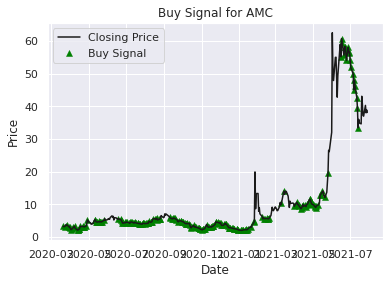

In [39]:
buy_df = buy_df.reset_index()
plt.plot(buy_sell_df.Date,buy_sell_df.Close,'-k', label = 'Closing Price')
plt.scatter(buy_df.Date, buy_df['Close'], color = 'green', label='Buy Signal', marker = '^', alpha = 1,LineWidth = 0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy Signal for {}'.format(tickersymbol))
plt.legend()
plt.savefig('./data/Plots/Buy_signal_for_{}.png'.format(tickersymbol))
plt.show()

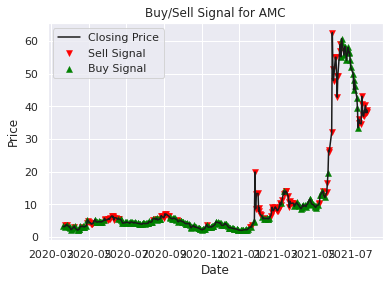

In [40]:

plt.plot(buy_sell_df.Date,buy_sell_df.Close,'-k', label = 'Closing Price')
plt.scatter(sell_df.Date, sell_df['Close'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1, LineWidth = 0.5)
plt.scatter(buy_df.Date, buy_df['Close'], color = 'green', label='Buy Signal', marker = '^', alpha = 1,LineWidth = 0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy/Sell Signal for {}'.format(tickersymbol))
plt.legend()
plt.savefig('./data/Plots/Buy_Sell_signal_for_{}.png'.format(tickersymbol))
plt.show()


# RNN LSTM model for price prediction (Ritika & Jyotiraditya)

In [41]:
#extracting historical data
start_date_train = '2016-6-1'
end_date_train = '2021-6-1'
tickerSymbol = df_combined_10['Ticker'][0]
# tickerSymbol = 'TSLA'
tickerdata = yf.Ticker(tickerSymbol)
tickerDF = tickerdata.history(period = '1d', start = start_date_train,end = end_date_train) # dates will go here
tickerDF['datetime'] = tickerDF.index
tickerDF = tickerDF.set_index('datetime')

# extracting VIX
vix = '^VIX'
tickerdata_vix = yf.Ticker(vix)
VIX_info = tickerdata_vix.history(period = '1d', start = start_date_train,end =end_date_train)
VIX_info['Vix_close'] = VIX_info['Close']
VIX_info = VIX_info[['Vix_close']]
VIX_info

combined = tickerDF.join(VIX_info,how = 'inner' )
combined = combined.fillna(0)
combined = combined[['Close','Open','Low','High','Volume','Vix_close']]


In [42]:
# Gathering training data

dataset_train = combined
training_set = dataset_train.iloc[:, 0:6].values

#feature scaling 
scaler =  MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)
scaler_predict = MinMaxScaler(feature_range=(0,1))
scaler_predict.fit_transform(training_set[:, 0:1])

X_train = []
y_train = []

timestamp = 60
num_rows = training_set_scaled.shape[0]
num_columns = training_set_scaled.shape[1]

for i in range(timestamp, num_rows):
    X_train.append(training_set_scaled[i-timestamp:i, 1:num_columns])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))


In [43]:
model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape = (X_train.shape[1], num_columns-1))) # change the values for layers
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True)) 
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True)) 
model.add(Dropout(0.2))

model.add(LSTM(units=64))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [44]:
model.fit(X_train, y_train,epochs= 30, batch_size=32) #epoch should be decided by converging of loss

Epoch 1/30
38/38 [==============================] - 11s 131ms/step - loss: 0.0286
Epoch 2/30
38/38 [==============================] - 5s 129ms/step - loss: 0.0072
Epoch 3/30
38/38 [==============================] - 5s 135ms/step - loss: 0.0066
Epoch 4/30
38/38 [==============================] - 5s 129ms/step - loss: 0.0065
Epoch 5/30
38/38 [==============================] - 5s 131ms/step - loss: 0.0061
Epoch 6/30
38/38 [==============================] - 5s 134ms/step - loss: 0.0058
Epoch 7/30
38/38 [==============================] - 5s 131ms/step - loss: 0.0055
Epoch 8/30
38/38 [==============================] - 5s 131ms/step - loss: 0.0055
Epoch 9/30
38/38 [==============================] - 5s 140ms/step - loss: 0.0058
Epoch 10/30
38/38 [==============================] - 5s 131ms/step - loss: 0.0050
Epoch 11/30
38/38 [==============================] - 5s 128ms/step - loss: 0.0051
Epoch 12/30
38/38 [==============================] - 5s 129ms/step - loss: 0.0049
Epoch 13/30
38/38 [=====

In [45]:
#get real stock price that you want to predict (here we used 2 month)

start_date_predict = '2021-6-1'
end_date_predict = '2021-8-1'
dataset_test_stock =  tickerdata.history(period = '1d', start = start_date_predict,end = end_date_predict)
dataset_test_vix =  tickerdata_vix.history(period = '1d', start = start_date_predict,end = end_date_predict)

dataset_test_vix['Vix_close'] = dataset_test_vix['Close']
dataset_test_vix = dataset_test_vix[['Vix_close']]

dataset_test = dataset_test_stock.join(dataset_test_vix,how = 'inner' )
dataset_test = dataset_test.fillna(0)

dataset_test = dataset_test[['Close','Open','Low','High','Volume','Vix_close']]

real_stock_close = dataset_test['Close'].values

dataset_test = dataset_test[['Close','Open','Low','High','Volume','Vix_close']]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - timestamp:].values
inputs = inputs.reshape(-1,6)

inputs = scaler.transform(inputs)

X_test = []
for i in range(timestamp, timestamp +dataset_test.shape[0] ):
    X_test.append(inputs[i-timestamp:i, 1:])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],5))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_predict.inverse_transform(predicted_stock_price)


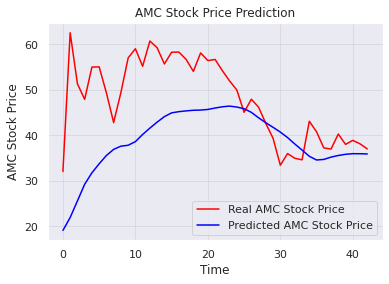

In [46]:
# Plotting the outcomes

plt.plot(real_stock_close, color = 'red', label = 'Real {} Stock Price'.format(tickerSymbol))
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted {} Stock Price'.format(tickerSymbol))
plt.title('{} Stock Price Prediction'.format(tickerSymbol))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(tickerSymbol))
plt.grid(which='major', color = '#cccccc', alpha = 0.5)
plt.legend()
plt.savefig('./data/Plots/RNN_stock_price_prediction_for_{}.png'.format(tickerSymbol))
plt.show()

# RNN LSTM model for price prediction using Sentiment Analysis 
(Jyotiraditya,  Navjot & Ritika)

In [47]:

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [48]:
# ticker, start_datetime, end_datetime
def get_score(data, **kwargs ):
  start_datetime = data.date1
  end_datetime = data.date2

  for i in kwargs:
       ticker = kwargs[i]

  api = PushshiftAPI()
  start = int(start_datetime.to_pydatetime().timestamp())
  end = int(end_datetime.to_pydatetime().timestamp())

  result = list(api.search_submissions(after=start, before = end,
                              q=ticker,
                              subreddit='wallstreetbets',
                              filter=['title'], limit=10))
  
  score = 0
  for r in result:
    text = r.title
    if len(text) > 512:
        text = text[:512]
    tokens = tokenizer.encode(text, return_tensors='pt')
    result = model(tokens)
    score += int(torch.argmax(result.logits))+1
  return score

In [49]:
# Gathering historical data 
start_date_train = '2021-3-1'
end_date_train = '2021-7-1'
tickerSymbol = df_combined_10['Ticker'][0]

tickerdata = yf.Ticker(tickerSymbol)
tickerDF = tickerdata.history(period = '1d', start = start_date_train,end = end_date_train) # dates will go here
tickerDF['datetime'] = tickerDF.index
tickerDF = tickerDF.set_index('datetime')

#extracting VIX
vix = '^VIX'
tickerdata_vix = yf.Ticker(vix)
VIX_info = tickerdata_vix.history(period = '1d', start = start_date_train,end =end_date_train)
VIX_info['Vix_close'] = VIX_info['Close']
VIX_info = VIX_info[['Vix_close']]

combined = tickerDF.join(VIX_info,how = 'inner' )
combined = combined.fillna(0)

combined = combined[['Close','Open','Low','High','Volume','Vix_close']]
combined['date1'] = combined.index
combined['date2'] = pd.DatetimeIndex(combined['date1']) + pd.DateOffset(1)
combined['score'] = combined.apply(get_score, ticker = tickerSymbol, axis =1)
combined = combined.drop(columns=['date1', 'date2'])


In [50]:
# Gathering training data 
dataset_train = combined
training_set = dataset_train.iloc[:, 0:7].values

#feature scaling
scaler =  MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

scaler_predict = MinMaxScaler(feature_range=(0,1))
scaler_predict.fit_transform(training_set[:, 0:1]);

X_train = []
y_train = []

timestamp = 60
num_rows = training_set_scaled.shape[0]
num_columns = training_set_scaled.shape[1]

for i in range(timestamp, num_rows):
    X_train.append(training_set_scaled[i-timestamp:i, 1:num_columns])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))



In [51]:
#get real stock price that you want to predict (here i used 2 month)
start_date_predict = '2021-7-1'
end_date_predict = '2021-8-1'
dataset_test_stock =  tickerdata.history(period = '1d', start = start_date_predict,end = end_date_predict)
dataset_test_vix =  tickerdata_vix.history(period = '1d', start = start_date_predict,end = end_date_predict)

dataset_test_vix['Vix_close'] = dataset_test_vix['Close']
dataset_test_vix = dataset_test_vix[['Vix_close']]

 

dataset_test = dataset_test_stock.join(dataset_test_vix,how = 'inner' )
dataset_test = dataset_test.fillna(0)

dataset_test = dataset_test[['Close','Open','Low','High','Volume','Vix_close']]

dataset_test['date1'] = dataset_test.index
dataset_test['date2'] = pd.DatetimeIndex(dataset_test['date1']) + pd.DateOffset(1)
dataset_test['score'] = dataset_test.apply(get_score, ticker = tickerSymbol, axis =1)
dataset_test = dataset_test.drop(columns=['date1', 'date2'])

real_stock_close = dataset_test['Close'].values

In [52]:
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


In [53]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape = (X_train.shape[1], num_columns-1))) # change the values for layers
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True)) 
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True)) 
model.add(Dropout(0.2))

model.add(LSTM(units=64))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [54]:
model.fit(X_train, y_train,epochs=50, batch_size=32) #epoch should be decided by converging of loss

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.6769
Epoch 2/50
1/1 [==============================] - 0s 121ms/step - loss: 0.4897
Epoch 3/50
1/1 [==============================] - 0s 137ms/step - loss: 0.3251
Epoch 4/50
1/1 [==============================] - 0s 130ms/step - loss: 0.1700
Epoch 5/50
1/1 [==============================] - 0s 131ms/step - loss: 0.0534
Epoch 6/50
1/1 [==============================] - 0s 138ms/step - loss: 0.0737
Epoch 7/50
1/1 [==============================] - 0s 134ms/step - loss: 0.1362
Epoch 8/50
1/1 [==============================] - 0s 139ms/step - loss: 0.0771
Epoch 9/50
1/1 [==============================] - 0s 134ms/step - loss: 0.0466
Epoch 10/50
1/1 [==============================] - 0s 138ms/step - loss: 0.0319
Epoch 11/50
1/1 [==============================] - 0s 144ms/step - loss: 0.0433
Epoch 12/50
1/1 [==============================] - 0s 127ms/step - loss: 0.0532
Epoch 13/50
1/1 [==============================] - 0

In [55]:
training_score = (model.evaluate(X_train, y_train))


1/1 [==============================] - 2s 2s/step - loss: 0.0230


In [56]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timestamp:].values
inputs = inputs.reshape(-1,7)

inputs = scaler.transform(inputs)

X_test = []
for i in range(timestamp, timestamp +dataset_test.shape[0] ):
    X_test.append(inputs[i-timestamp:i, 1:])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],6))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_predict.inverse_transform(predicted_stock_price)


Training Score = 0.023006277158856392


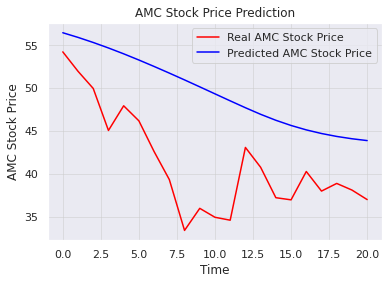

In [57]:
print('Training Score = {}'.format(training_score))
plt.plot(real_stock_close, color = 'red', label = 'Real {} Stock Price'.format(tickerSymbol))
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted {} Stock Price'.format(tickerSymbol))
plt.title('{} Stock Price Prediction'.format(tickerSymbol))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(tickerSymbol))
plt.grid(which='major', color = '#cccccc', alpha = 0.5)
plt.legend()
plt.savefig('./data/Plots/BERT_RNN_stock_price_prediction_for_{}.png'.format(tickersymbol))
plt.show()